In [49]:
%pip install matplotlib --break-system-packages
%pip install seaborn --break-system-packages

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from scipy.stats import kstest
import matplotlib.pyplot as plt

### 1. Como estimar $\pi$ usando Monte Carlo?

Introduzimos um quadrado $\mathcal{S} \subset \mathbb{R}^2$, de lados de tamanho 2, com um disco $\mathcal{D}$ de raio 1 inscrito. Estamos interesados na area $\mathit{I}$ de $\mathcal{D}$ usando Monte Carlo. Temos

\begin{align*}
I &= \pi = \int \int_{\mathcal{D}} dx_1 dx_2 \\
&= \int \int_{\mathcal{S}} \mathbb{I}_\mathcal{D}(x_1, x_2) dx_1 dx_2, \mathcal{D} \subset \mathcal{S} \\
&= 4 \int \int_{\mathbb{R}^2} \mathbb{I}_\mathcal{D}(x_1, x_2) \mu(x_1, x_2) dx_1 dx_2
\end{align*}

onde $\mathcal{S} := [-1, 1] \times [-1, 1]$ e

$$
\mu(x_1, x_2) = \frac{1}{4} \mathbb{I}_\mathcal{S} (x_1, x_2)
$$

é uma distribuição uniforme no quadrado $\mathcal{S}$. Neste caso, temos

$$
\hat{I}_n = 4 \frac{n_\mathcal{D}}{n}
$$

onde $n_\mathcal{D}$ é o numero de amostras que caem no disco.

In [26]:
# Start variables
n_repeats = 100
n_points = 1000
r = 1 #radius
C = np.array([1, 1]) #center of circle
l = 2 #size of square

# Draw a num_points x 2 matrix of independent U[0, 1] random variables.
U = np.random.uniform(0, 2, size=(n_points, 2))

# Compute index mask of all points that are inside the circle.
inside = (U[:, 0] - C[0])**2 + (U[:, 1] - C[1])**2 < r**2

# Count the number of points inside the disk.
M = np.sum(inside)

# Monte Carlo estimate of pi
pi_estimate = (M / n_points) * (l**2 / r**2)
print(f"Monte Carlo estimate of pi: {pi_estimate:.4f}")

Monte Carlo estimate of pi: 3.1760


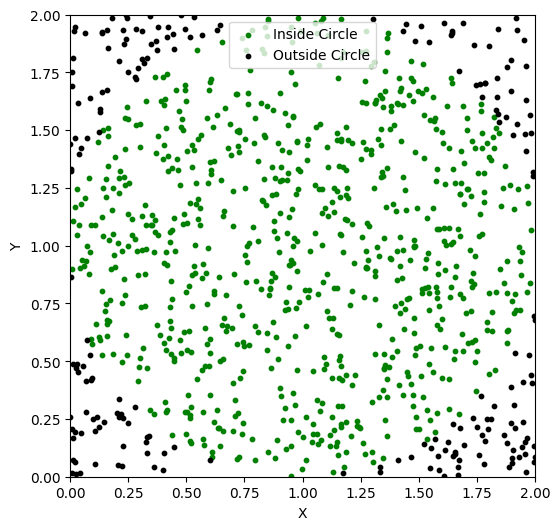

In [27]:
# Plot the points: green for points inside the circle, black for the others.
plt.figure(figsize=(6, 6))
plt.scatter(U[inside, 0], U[inside, 1], color="green", label="Inside Circle", s=10)
plt.scatter(U[~inside, 0], U[~inside, 1], color="black", label="Outside Circle", s=10)
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.legend()
plt.show()

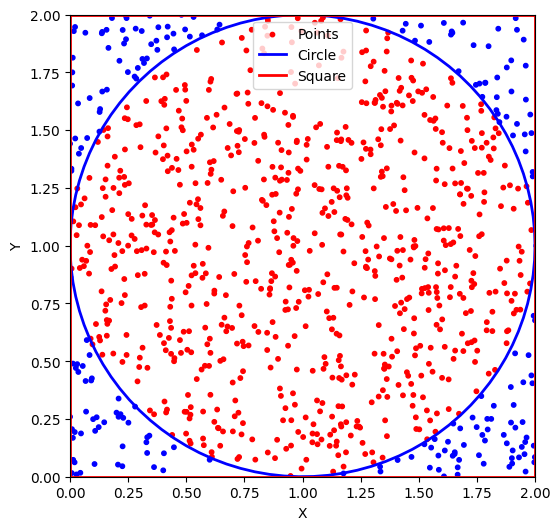

In [28]:
# Create the plot
plt.figure(figsize=(6, 6))
plt.scatter(U[:, 0], U[:, 1], c=inside, cmap="bwr", label="Points", s=10)

# Draw the circle
theta = np.linspace(0, 2 * np.pi, 100)
circle_x = C[0] + r * np.cos(theta)
circle_y = C[1] + r * np.sin(theta)
plt.plot(circle_x, circle_y, color="blue", linewidth=2, label="Circle")

# Draw the square
square_x = [0, l, l, 0, 0]
square_y = [0, 0, l, l, 0]
plt.plot(square_x, square_y, color="red", linewidth=2, label="Square")

# Labels and legend
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.legend()
plt.show()

In [32]:
# Store the results per experiment and per number of points used
online_errors = np.zeros((n_points, n_repeats))

# Repeat the experiment num_repeats times
for i in range(n_repeats):
    # Generate uniform samples
    U = np.random.uniform(0, 2, size=(n_points, 2))
    
    # Count points that fell inside the disk for each sample size up to num_points
    M = np.cumsum((U[:, 0] - C[0])**2 + (U[:, 1] - C[1])**2 < r**2)
    
    # Compute the relative error = (estimate - true value) / true value
    online_estimate = M / np.arange(1, n_points + 1) * (l**2 / r**2)
    online_errors[:, i] = (online_estimate - np.pi) / np.pi

# Convert results into a DataFrame for easier plotting
df_errors = pd.DataFrame(online_errors)
df_errors = df_errors.melt(ignore_index=False, var_name="run", value_name="error")
df_errors.reset_index(inplace=True)
df_errors.rename(columns={"index": "samples"}, inplace=True)

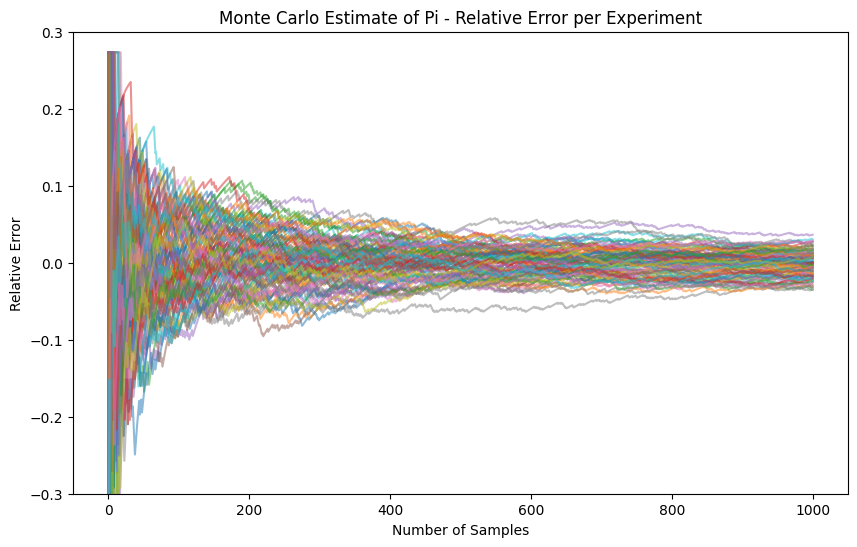

In [33]:
# Plot error vs number of samples for each experiment
plt.figure(figsize=(10, 6))
for run in df_errors["run"].unique():
    subset = df_errors[df_errors["run"] == run]
    plt.plot(subset["samples"], subset["error"], alpha=0.5)

# Customize the plot
plt.ylim(-0.3, 0.3)
plt.xlabel("Number of Samples")
plt.ylabel("Relative Error")
plt.title("Monte Carlo Estimate of Pi - Relative Error per Experiment")
plt.show()

### 2. Implemente o algoritmo de Box-Muller.

In [44]:
def box_muller(size: int):
    n_pairs = int(np.ceil(size / 2))
    
    R = np.sqrt(-2 * np.log(np.random.uniform(size=n_pairs)))
    theta = 2 * np.pi * np.random.uniform(size=n_pairs)
    
    X = R * np.cos(theta)
    Y = R * np.sin(theta)
    
    return np.concatenate((X, Y))[:size]

In [58]:
samples = box_muller(10001)

In [59]:
print(f"len of samples: {len(samples)}")

len of samples: 10001


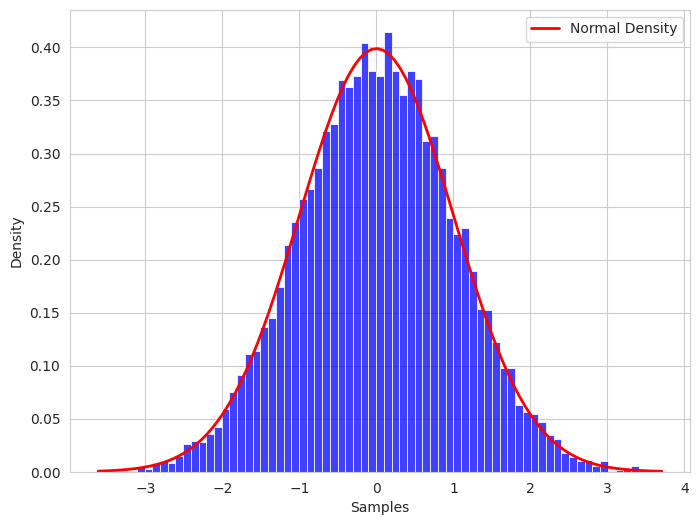

In [60]:
# Set Seaborn theme
sns.set_style("whitegrid")

# Create histogram
plt.figure(figsize=(8, 6))
sns.histplot(samples, bins=int((max(samples) - min(samples)) / 0.1), kde=False, stat="density", color="blue")

# Superimpose normal density curve
xs = np.linspace(min(samples), max(samples), 100)
ys = norm.pdf(xs)
plt.plot(xs, ys, color="red", linewidth=2, label="Normal Density")

# Labels and show plot
plt.xlabel("Samples")
plt.ylabel("Density")
plt.legend()
plt.show()

In [61]:
# Perform the KS test
ks_statistic, p_value = kstest(samples, "norm")

print(f"KS Statistic: {ks_statistic:.4f}, p-value: {p_value:.4f}")

KS Statistic: 0.0108, p-value: 0.1889
